<a href="https://colab.research.google.com/github/Lucas01iveira/MAC-0115/blob/main/Projeto3_Ising2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import imageio
import os

In [2]:
from google.colab import files 
!rm *

rm: cannot remove 'sample_data': Is a directory


# Definição das funções importantes do código
  - Função (1): Cria um sistema numa malha 2d NxN
  - Função (2): Plota a representação dessa malha no plano 
  (spin up -> quadradinho preto / spin down -> quadradinho branco)
  - Função (3): Atualiza a matriz do sistema considerando o algoritmo de Metropolis
  - Função (4): Calcula a magnetização do sistema
  - Função (5): Apresenta a evolução do sistema (para um certo número de varreduras / iterações) através de um Gif

###  Função (1): Cria um sistema numa malha 2d NxN

In [3]:
# Defino uma função que cria um sistema 2d de spins numa malha quadrada NxN

def cria_sistema(N):
  # -------------------------------------------------------------------------
  # Parâmetros de entrada:
    # - N: 'tamanho' do sistema

  # Valores de saída:
    # - M: matriz NxN com os spins aleatoriamente distribuídos no sistema
  # -------------------------------------------------------------------------

  M = [] # matriz M a ser preenchida

  for i in range(N): # para cada linha
    vec_spins = [] # define um vetor auxiliar de preenchimento

    for j in range(N): # para cada coluna 
      aux = np.random.uniform(0,1) # sorteia um número entre 0 e 1
      if aux > 1/2: # se for maior que 1/2
        vec_spins.append(+1) # inclui, na coluna 'j', o spin +1
      else: # caso contrário
        vec_spins.append(-1) # inclui, na coluna 'j', o spin -1

    # ao final do preenchimento de cada coluna, acrescenta o vetor vec_spins na linha 'i' de M
    M.append(vec_spins) 

  return M

In [4]:
# (teste de funcionamento) - Okay!
sist = cria_sistema(3)
for i in sist:
  print(i)

[1, -1, 1]
[1, 1, 1]
[-1, -1, 1]


### Função (2): Plota a representação dessa malha no plano 
  (spin up -> quadradinho preto / spin down -> quadradinho branco)

In [5]:
# Defino uma função que apresenta o sistema de spins em uma representação bidimensional
  
# Obs.: no caso dessa figura a correspondência entre a matriz de spins do sistema e o plot 
# está na ordem correta. (a função imshow já faz isso automaticamente!!!)

def cria_figura(M):

  # -------------------------------------------------------------------------
  # Parâmetros de entrada:
    # - M: matriz do sistema de spins

  # Valores de saída:
    # - Figura quadriculada representando os spins/dipolos up e down do sistema.
    # (quadradinho preto -> spin up   )
    # (quadradinho branco -> spin down)

  # -------------------------------------------------------------------------
  
  ax = plt.figure(figsize=(10,7))
  M_size = len(M) # tamanho do sistema

  # inclui explicitamente as divisões associadas ao "espaço" de cada spin

  for i in range(M_size):
    if i < M_size-1:
      ax = plt.axhline(i+0.5, color='black')
      ax = plt.axvline(i+0.5, color='black')

  # Utiliza a função 'imshow' para apresentar os spins do sistema.
  # Há alguns casos específicos para os quais o 'colormap'
  # deve ser definido de maneira individualizada para manter a coerência
  # da convenção de cores definida

  conta_elementos = 0
  for i in range(M_size):
    for j in range(M_size):
      conta_elementos += M[i][j]

  if conta_elementos == M_size*M_size:
    # se todos os elementos forem iguais a +1, então a contagem deve ser igual à 
    # quantidade de termos da matriz (M_size*M_size)
    ax = plt.imshow(M, cmap='gray') # (cmap = 'gray' já começa na cor preta)

  elif conta_elementos == - M_size*M_size:
    # se todos os elementos forem iguais a -1, então a contagem deve ser igual à 
    # (-) a quantidade de termos da matriz (ou seja, - M_size*M_size)
    ax = plt.imshow(M, cmap='binary') # (cmap = 'binary' já começa na cor branca) 
  
  else:
    # se a contagem não for igual a M_size*M_size nem a M_size*M_size, então
    # quer dizer que o sistema tem uma quantidade variada de spins 

    ax = plt.imshow(M, cmap='binary')
    # nesse caso há termos -1 e +1, então o cmap = 'binary' já dará conta de ajustar
    # as cores adequadamente

  plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)


[1, -1, 1]
[1, 1, 1]
[-1, -1, 1]


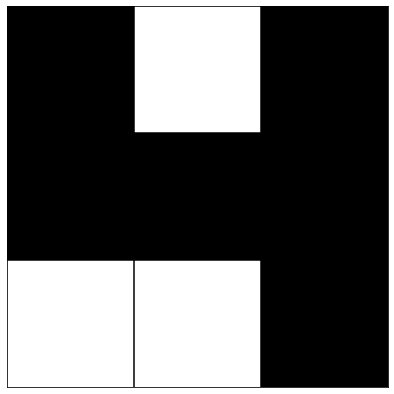

In [6]:
# (teste de funcionamento) - Okay!
for i in sist:
  print(i)
cria_figura(sist)

### Função (3): Atualiza a matriz do sistema considerando o algoritmo de Metropolis

- Antes de definir a função de atualização da matriz de spins do sistema com base no algoritmo de Metrópolis, defino duas funções auxiliares:
  - Cálculo da energia com base no Hamiltoniano de Ising
  - Cálculo da variação de energia com base nas contas manuais (supondo um flip no spin da posição (k,m)
  $$ \Delta E = 2\cdot \sigma_{km} \cdot \{ \epsilon \cdot [\sigma_{k(m+1)} + \sigma_{k(m-1)} + \sigma_{(k-1)m} + \sigma_{(k+1)m} ]  + h \}$$
  - Verificação da possibilidade do flip

In [7]:
# Defino uma função que calcula a energia do sistema com base no modelo do Hamiltoniano de Ising

def calcula_E(eps, h, M):
  # -------------------------------------------------------------------------

  # Parâmetros de entrada:
    # - eps: parâmetro de energia do hamiltoniano
    # - h: parâmetro de campo magnético
    # - M: matriz de spins do sistema

  # !!! UNIDADES ESPECIAIS TAIS QUE KB = 1 !!! # 

  # Valores de saída: 
    # - E: energia do sistema

  # -------------------------------------------------------------------------

  M_size = len(M) # tamanho do sistema

  # soma associada ao termo de energia (propriamente dita)
  soma_1 = 0 

  # Cuida inicialmente das bordas problemáticas
  # 0) Último termo (i = M_size-1, j = M_size-1)
  i = M_size-1
  j = M_size-1
  soma_1 += M[i][j]*M[i][0] + M[i][j]*M[i][j-1] + M[i][j]*M[i-1][j] + M[i][j]*M[0][j]
  # lógica: # direita / esquerda / cima / baixo


  # 1) Última coluna (j = M_size-1)
  j = M_size-1 
  for i in range(M_size-1): # range até M_size-1 porque o último elemento de M já foi considerado
    soma_1 += M[i][j]*M[i][0] + M[i][j]*M[i][j-1] + M[i][j]*M[i-1][j] + M[i][j]*M[i+1][j]
    # lógica: # direita / esquerda / cima / baixo

  # 2) Última linha (i = M_size-1)
  i = M_size-1
  for j in range(M_size-1): # range até M_size-1 porque o último elemento de M já foi considerado
    soma_1 += M[i][j]*M[i][j+1] + M[i][j]*M[i][j-1] + M[i][j]*M[i-1][j] + M[i][j]*M[0][j]
    # lógica: # direita / esquerda / cima / baixo
  
  # Faz um loop para acrescentar os termos correspondentes ao interior da matriz de spins do sistema
  # (range até M_size-1 por que a última linha e a última coluna já foram contabilizadas)
  for i in range(M_size-1):
    for j in range(M_size-1):
      soma_1 += M[i][j]*M[i][j+1] + M[i][j]*M[i][j-1] + M[i][j]*M[i-1][j] + M[i][j]*M[i+1][j]
      # direita / esquerda / cima / baixo
  
    
  # --------------------------------------------------------------------------
  
  # soma associada ao termo de campo magnético
  # (soma sobre todos os spins do sistema)
  soma_2 = 0 

  for i in range(M_size): # para cada linha
    for j in range(M_size): # para cada coluna
      soma_2 += M[i][j] # acrescenta o valor do spin[i][j] na soma
  
  # --------------------------------------------------------------------------

  # Calcula a energia e retorna a função
  E = - eps*soma_1 - h*soma_2

  return E

In [8]:
# (teste de funcionamento) - Okay!
A = cria_sistema(2)
for i in A:
  print(i)
calcula_E(1,0,A)

[1, 1]
[-1, 1]


0

In [9]:
teste_m = [[1,1,1], [-1,1,1], [1,-1,1]]
calcula_E(1,0,teste_m)

-4

In [10]:
# defino uma função auxiliar que calcula a variação de energia do flip considerando
# considerando o cálculo manual 

def calcula_DeltaE(eps, h, M, i_flip, j_flip):
  # -------------------------------------------------------------------------

  # Parâmetros de entrada:
    # - M: matriz de spins do sistema
    # - i_flip: linha do spin a ser alterado
    # - j_flip: coluna do spin a ser alterado

  # Valores de saída:
    # - Variação de energia do flip correspondente

  # -------------------------------------------------------------------------
  #print(M)
  #M_size = np.shape(M)[0]

  M_size = len(M) # tamanho do sistema
  
  if i_flip == M_size-1: # verifica se está na última linha 
    if j_flip == M_size-1: # verifica se está no último termo
      #Delta_E = 2*M[i_flip][j_flip]*( 2*eps*( M[i_flip][0] + M[i_flip][j_flip-1] + M[i_flip-1][j_flip] + M[0][j_flip]) + h )
      Delta_E = 2*M[i_flip][j_flip]*( eps*( M[i_flip][0] + M[i_flip][j_flip-1] + M[i_flip-1][j_flip] + M[0][j_flip]) + h )

    else: # se está na última linha, mas não no último termo,
      #Delta_E = 2*M[i_flip][j_flip]*( 2*eps*( M[i_flip][j_flip+1] + M[i_flip][j_flip-1] + M[i_flip-1][j_flip] + M[0][j_flip]) + h )
      Delta_E = 2*M[i_flip][j_flip]*( eps*( M[i_flip][j_flip+1] + M[i_flip][j_flip-1] + M[i_flip-1][j_flip] + M[0][j_flip]) + h )

  else: # se não está na última linha
    if j_flip == M_size-1: # verifica se está na última coluna
      #Delta_E = 2*M[i_flip][j_flip]*( 2*eps*( M[i_flip][0] + M[i_flip][j_flip-1] + M[i_flip-1][j_flip] + M[i_flip+1][j_flip]) + h )
      Delta_E = 2*M[i_flip][j_flip]*( eps*( M[i_flip][0] + M[i_flip][j_flip-1] + M[i_flip-1][j_flip] + M[i_flip+1][j_flip]) + h )

    else: # se não está nem na última linha, nem na última coluna, atualiza normalmente
      #Delta_E = 2*M[i_flip][j_flip]*( 2*eps*( M[i_flip][j_flip+1] + M[i_flip][j_flip-1] + M[i_flip-1][j_flip] + M[i_flip+1][j_flip]) + h)
      Delta_E = 2*M[i_flip][j_flip]*( eps*( M[i_flip][j_flip+1] + M[i_flip][j_flip-1] + M[i_flip-1][j_flip] + M[i_flip+1][j_flip]) + h)

  #print(Delta_E)
  # Delta_E = Delta_E * (-1)
  return Delta_E

In [11]:
# (teste de funcionamento) - Okay!
# TESTE FEITO EM OUTRO COLAB (ESTÁ TD CERTO)

In [12]:
# Defino uma função que verifica se o spin da posição [i_flip, j_flip] pode ser flipado ou não
# (é aqui que entra a essência do algoritmo de Metrópolis)

def verifica_flip(T, i_flip, j_flip, eps, h, M):
  # -------------------------------------------------------------------------

  # Parâmetros de entrada
    # - T: temperatura
    # - i_flip: índice da linha 
    # - j_flip: índice da coluna
    # - eps: parâmetro de energia do hamiltoniano
    # - h: parâmetro de campo magnético
    # - M: matriz de spins do sistema

  # !!! UNIDADES ESPECIAIS TAIS QUE KB = 1 !!! # 

  # Valores de saída  
    # - True: se o spin do sistema puder ser alterado
    # - False: se o spin do sistema não puder ser alterado

  # -------------------------------------------------------------------------

  # Cálculo da variação de energia associada à alteração de um spin do sistema
  Delta_E = calcula_DeltaE(eps, h, M, i_flip, j_flip)

  if Delta_E < 0: # se a variação de energia for negativa, o flip pode ser efetuado
    return True
  else: # se não
    # faço um sorteio e verifico a probabilidade do flip acontecer
    r = np.random.uniform(0,1)
    prob_flip = np.exp(-Delta_E/T)
    
    if r < prob_flip: # se o número sorteado 'estiver dentro da probabilidade do flip', o flip pode ser efetuado
      return True
    else: # caso contrário, o flip não pode ser efetuado
      return False

- Defino a função de atualização da matriz de spins do sistema

In [13]:
# Defino uma função que atualiza o sistema de spins e retorna uma nova matriz atualizada
# (atualização efetuada com base no algoritmo de Metropolis)
# LEMBRANDO QUE A ATUALIZAÇÃO PELO ALGORITMO DE METROPOLIS PEGA SPINS ALEATÓRIOS DO SISTEMA # 
# (faz isso até que tenham sido tomados todos)

def atualiza_Metropolis(T, eps, h, M):
  # -------------------------------------------------------------------------
  
  # Parâmetros de entrada:
    # - eps: parâmetro de energia do hamiltoniano
    # - h: parâmetro de campo magnético
    # - M: matriz de spins do sistema

  # Valores de saída:
    # A função não retorna nenhuma saída, apenas altera (atualiza) os valores na matriz M fornecida 

  # -------------------------------------------------------------------------
  M_size = len(M) # tamanho do sistema

  # vetor auxiliar
  aux1 = [] # guarda "índices-linha" sorteados de M

  # inicia um loop para sortear linhas aleatórias da matriz M
  while len(aux1) != M_size: 
    lin = np.random.randint(0,M_size) # sorteia o índice de uma linha qualquer

    if lin not in aux1: # se o índice sorteado não está no vetor aux1, 
      aux1.append(lin) # guarda no vetor aux1

      # Para cada linha sorteada, faz um sorteio dos spins contidos em todas as colunas
      aux2 = [] # guarda "índices-coluna" sorteados de M

      while len(aux2) != M_size:
        col = np.random.randint(0,M_size) # sorteia o índice de uma coluna qualquer
        if col not in aux2: # se o índice sorteado não está no vetor aux2
          aux2.append(col) # guarda no vetor aux2

          if verifica_flip(T, lin, col, eps, h, M) == True: # verifica a possibilidade do flip de spin
            M[lin][col] = (-1)*M[lin][col]

      # O loop é repetido até que todas as colunas da linha 'lin' tenham sido sorteadas
  

In [14]:
# Função teste percorrendo a matriz de spins do sistema com base em vetores de
# linhas/colunas embaralhadas (sugestão do Lauro)

def TESTE_atualiza_Metropolis(T, eps, h, M):
  M_size = len(M)
  aux_linhas = np.arange(0, M_size, 1)
  aux_colunas = np.arange(0, M_size, 1)

  np.random.shuffle(aux_linhas) # embaralha o vetor de linhas
  np.random.shuffle(aux_colunas) # embaralha o vetor de colunas

  for i_flip in aux_linhas:
    for j_flip in aux_colunas:
      if verifica_flip(T, i_flip, j_flip, eps, h, M) == True:
        M[i_flip][j_flip] = (-1)*M[i_flip][j_flip]
  

Sistema inicial:

Novo sistema:


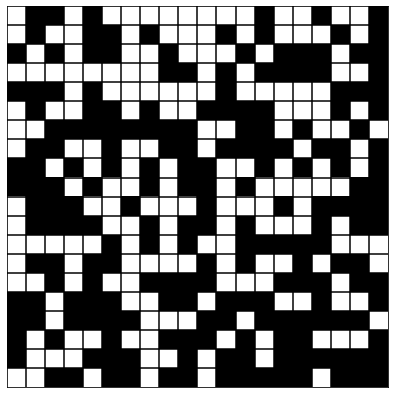

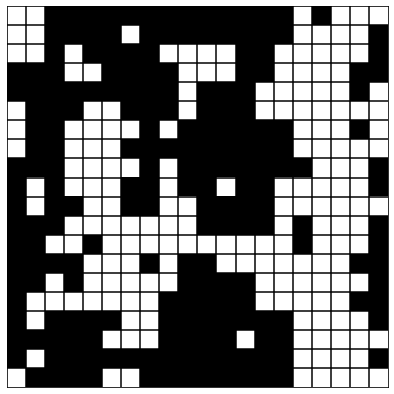

In [15]:
# (teste de funcionamento) - Okay!
sist = cria_sistema(20)
print('Sistema inicial:')
cria_figura(sist)

for i in range(50):
  TESTE_atualiza_Metropolis(3,1,0,sist)
print()

print('Novo sistema:')
cria_figura(sist)

### Função (4): Calcula a magnetização do sistema

In [16]:
# Defino uma função para calcular a magnetização do sistema

def calcula_Mag(M):
  # -------------------------------------------------------------------------
  # Parâmetros de entrada:
    # - M: matriz de spins do sistema

  # Valores de saída:
    # - magnetização média do sistema (em módulo)
  # -------------------------------------------------------------------------

  #return np.abs(np.mean(M))
  return np.mean(M)

### Função (5): Apresenta a evolução do sistema (para um certo número de varreduras / iterações) através de um Gif

- Função recreativa
  - Defino uma função que apresenta a atualização do sistema de maneira animada (como um gif)

In [17]:
!rm *
!rm -rf pasta_frames

rm: cannot remove 'sample_data': Is a directory


In [18]:
# Defino uma função para criar um gif mostrando a 'evolução temporal' de um determinado sistema de spins

def cria_gif(T, eps, h, M, N_frames, Name):
  # -------------------------------------------------------------------------
  # Parâmetros de entrada
    # - T: temperatura de equilíbrio do sistema
    # - eps: constante de energia 
    # - h: parâmetro de campo magnético
    # - M: matriz do sistema inicial 
    # - N_frames: número de frames desejado
    # - Name: (str) nome do arquivo.gif

  # Valores de saída:
    # - Gif de evolução do sistema a cada iteração sobre o conjunto de spins
  # -------------------------------------------------------------------------
  M_size = len(M) # tamanho do sistema
  filenames = [] # vetor auxiliar para guardar o nome das figuras que compõem cada frame do gif
  ax = plt.figure(figsize=(9,6))
  
  !mkdir pasta_frames # crio um diretório dentro do colab para guardar as figuras de cada frame
  for a in range(N_frames): # para cada frame
    for i in range(5):
      # Constrói a figura a ser apresentada (adaptado da função plota_sistema)

      # ____________________________________________________________________________________
      for i in range(M_size):
        if i < M_size-1:
          ax = plt.axhline(i+0.5, color='black')
          ax = plt.axvline(i+0.5, color='black')

      conta_elementos = 0
      for l in range(M_size):
        for c in range(M_size):
          conta_elementos += M[l][c]

      if conta_elementos == M_size*M_size:
        ax = plt.imshow(M, cmap='gray') # (o cmap = 'gray' já começa na cor preta)
      elif conta_elementos == - M_size*M_size:
        ax = plt.imshow(M, cmap='binary') 
      else:
        ax = plt.imshow(M, cmap='binary')

      plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
      # ____________________________________________________________________________________

      # construção dos frames do gif
      filename = 'frame_{}.png'.format(a)
      filenames.append(filename)

      if a == N_frames-1: # se estiver no último frame do gif 
        for k in range(5):
          filenames.append(filename) # acrescenta uma pausa maior

      plt.savefig('pasta_frames/{}'.format(filename)) # salvo as figuras dentro do diretório criado
      plt.close()

    # Atualiza o sistema para construir o frame seguinte 
    if a < N_frames-1:
      #atualiza_Metropolis(T, eps, h, M)
      TESTE_atualiza_Metropolis(T, eps, h, M)

  # Cria o gif 
  with imageio.get_writer('{}.gif'.format(Name), mode='I') as writer:
    for filename in filenames:
      image = imageio.imread('pasta_frames/{}'.format(filename))
      writer.append_data(image)
  
  !rm -rf pasta_frames # deleto o diretório de figuras criado


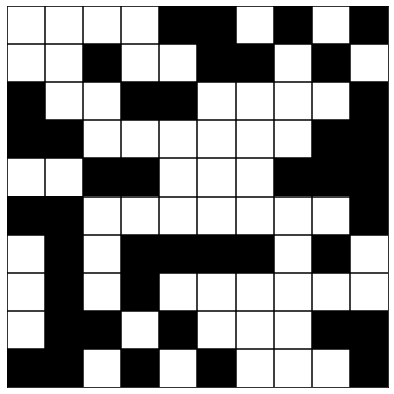

In [ ]:
# (teste de funcionamento) - Okay!
A = cria_sistema(10)
cria_figura(A)
plt.show()

#cria_gif(1,1,0,A,20,'teste1')

#cria_figura(A)
#plt.show()

### Help!

In [ ]:
cria_sistema??

In [ ]:
cria_figura??

In [ ]:
atualiza_Metropolis??

In [ ]:
calcula_Mag??

## Análises solicitadas (Gregóriozada)
  - Para h = 0 e J = 1, calcular a magnetização média de um sistema N=10 (10x10) (pelo menos) após 1000 varreduras em função da temperatura.
    - Fazer alguns testes com N = 100 e N = 1000 para as mesmas temperaturas (verificar o que acontece com N -> inf)
  - Falar (utilizando as figuras / i.e., graficamente) sobre a transição de fase: limite de alteração de comportamento Ferromagneto <-> Paramagneto e vice-versa (ou seja, quando um ferromagneto deixa de apresentar magnetização espontânea)
  - Explicar por que a magnetização espontânea não acontece no caso 1d 

- Como forma de verificar diretamente que os códigos estão funcionando da maneira correta, será feita uma verificação da solução analítica de Onsager para a magnetização espontânea do sistema no caso em que $h = 0$ (provada matematicamente algum tempo depois por C.N. Yang)

$$
M = (1 - [\sinh(2\beta \epsilon_1) \sinh(\beta \epsilon_2)]^{-2})^{\frac{1}{8}}
$$

sendo $\epsilon_1$ e $\epsilon_2$ os parâmetros de interação entre spins para cada direção do sistema bidimensional e $\beta = \frac{1}{k_B T}$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


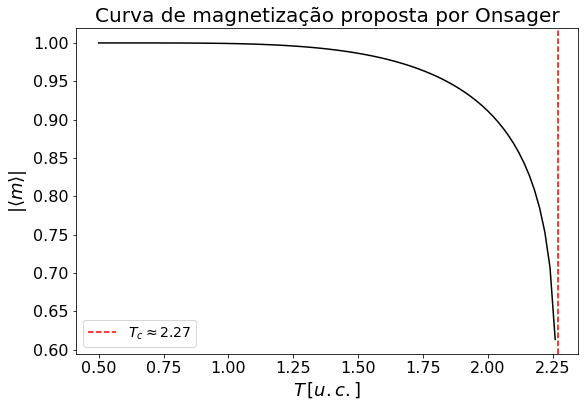

In [ ]:
 # Plot da solução de Onsager
T_plot = np.arange(0.5,3,0.02)
eps = 1 # eps1 = eps2 = eps (assumindo isotropia)
m_plot = (1 - (np.sinh(2*eps/T_plot) * np.sinh(2*eps/T_plot))**(-2) )**(1/8)

ax = plt.figure(figsize=(9,6))
plt.title('Curva de magnetização proposta por Onsager', fontsize=20)
plt.ylabel(r'|$\langle m \rangle$|', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel(r'$T \,[ u.c.]$', fontsize=18)
plt.xticks(fontsize=16)

plt.plot(T_plot, m_plot, linestyle='solid', color='black')
plt.axvline(2/(np.log(1+np.sqrt(2))), linestyle='dashed', color='red', label=r'$T_c \approx 2.27$')
plt.legend(fontsize=14)

plt.show()

- Análise da transição de fase

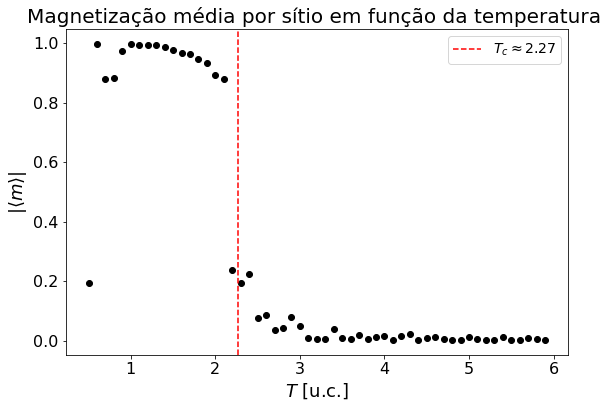

In [ ]:
# Caso h = 0 e epsilon = 1 

T = np.arange(0.5,6,0.1) # vetor de temperaturas
eps = 1 # parâmetro de energia
h = 0 # parâmetro de campo magnético
Nvar = 1000 # número de varreduras
mag_mean = [] # vetor para armazenar a magnetização média final obtida para cada temperatura
sist = cria_sistema(10) # define um sistema de spins 50x50
#plota_sistema(sist)
#plt.show()

for i in range(len(T)): # para cada temperatura
  sist_aux = np.copy(sist) # copia o sistema inicial de spins criado
  #sist_aux = cria_sistema(15)
  mag = [] # vetor para armazenar a magnetização do sistema para cada varredura

  mag.append(calcula_Mag(sist_aux)) # calcula a magnetização inicial do sistema criado
  for j in range(Nvar): # para cada varredura
    #atualiza_Metropolis(T[i], eps, h, sist_aux)
    TESTE_atualiza_Metropolis(T[i], eps, h, sist_aux) # atualiza o sistema
    mag.append(calcula_Mag(sist_aux)) # calcula a magnetização e guarda

  mag_mean.append(np.abs(np.mean(mag))) # armazena a magnetização média do sistema

# Apresenta o gráfico correspondente
ax = plt.figure(figsize=(9,6))
ax = plt.scatter(T, mag_mean, color='black')
plt.title('Magnetização média por sítio em função da temperatura ', fontsize=20)
plt.ylabel(r'|$\langle m \rangle|$', fontsize=18)
plt.xlabel('$T$ [u.c.]', fontsize=18)
plt.axvline(x = 2.27, color='red',linestyle='dashed', label=r'$T_c \approx 2.27$')
plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.ylim(0,1.5)
plt.show()

Sistema inicial


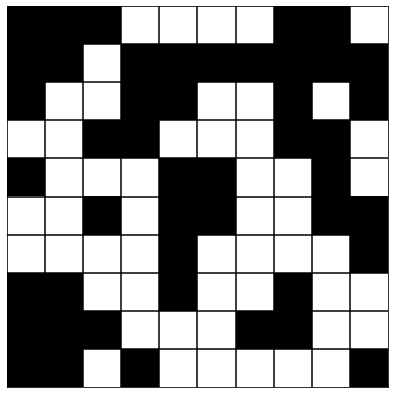


------------------------------
T = 1


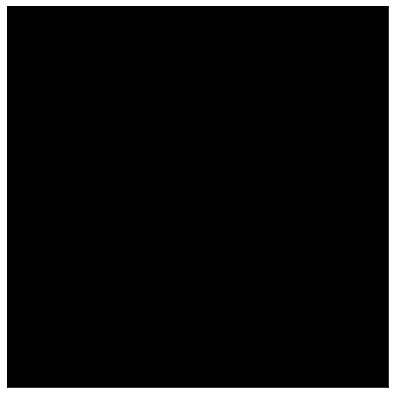


T = 2


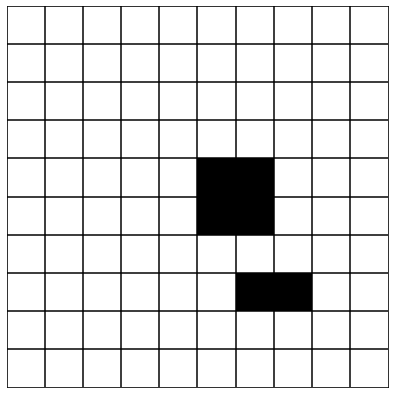


T = 3


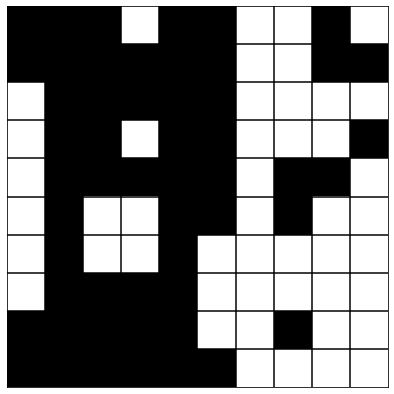


T = 6


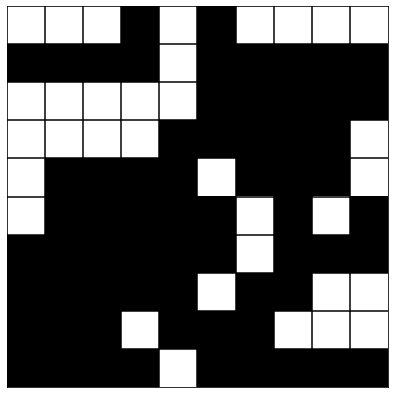


T = 9


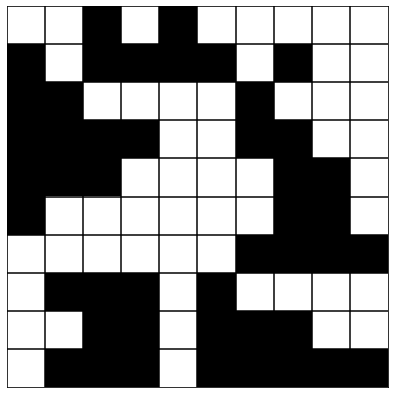

In [ ]:
'''
sist = cria_sistema(10) # cria um sistema inicial
eps = 1 # constante de energia 
h = 0 # campo magnético desligado
Nvar = 100 # quantidade de iterações por simulação
T = [1, 2, 3, 6, 9] # vetor de temperaturas

print('Sistema inicial')
cria_figura(sist)
plt.show()
print()
print('-'*30)
for i in range(len(T)):
  sist_aux = np.copy(sist)

  cria_gif(T[i], eps, h, sist_aux, Nvar, 'T={}'.format(T[i]))
  # lembrando que a função cria_gif já atualiza diretamente a matriz fornecida 
  # (então de fato a sequência de frames apresentada no gif é a sequência de atualizações
  # pela qual o sistema mesmo!)

  #for j in range(Nvar):
  #  TESTE_atualiza_Metropolis(T[i], eps, h, sist_aux)

  print('T = {}'.format(T[i]))
  cria_figura(sist_aux)
  plt.show()
  print()
'''

# Atenção! A sequência de códigos acima foi executada uma única vez para 
# salvar as configurações / gifs e utilizar no relatório. 

# Se executada novamente, serão obtidos novos sistemas de spins e sequências de atualização
# distintas uma vez que o processo de flip de spins é randômico / probabilístico.

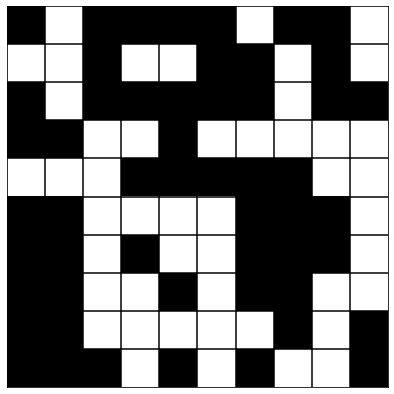

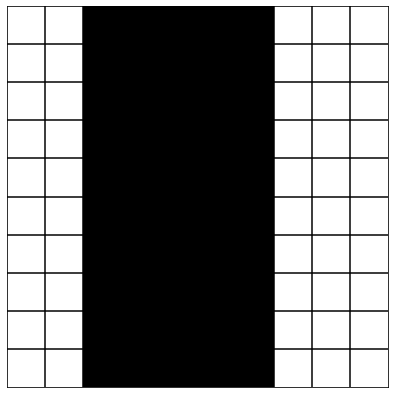

In [ ]:
'''A = cria_sistema(10)
cria_figura(A)

for i in range(1000):
  TESTE_atualiza_Metropolis(0.2,1,0,A)

cria_figura(A)
print(calcula_mag(A))
'''
# Sequência de códigos rodada uma única vez 

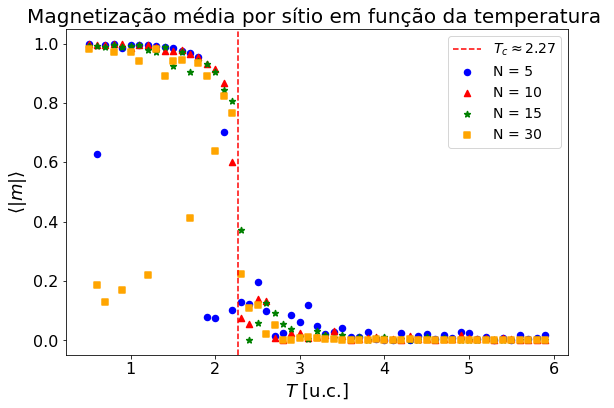

In [21]:
# efeito do tamanho do sistema

T = np.arange(0.5,6,0.1) # vetor de temperaturas
eps = 1 # parâmetro de energia
h = 0 # parâmetro de campo magnético
Nvar = 1000 # número de varreduras (pela metade para ganhar +tempo)
N = [5, 10 ,15, 30] # vetor de 'tamanhos' da matriz de spins

ax = plt.figure(figsize=(9,6))
markers = ['o', '^', '*', 's']
colors = ['blue', 'red', 'green', 'orange']


for i in range (len(N)): # para cada tamanho de sistema
  sist = cria_sistema(N[i]) # defino um sistema randômico de spins
  mag_mean = [] # vetor para armazenar a magnetização media final obtida para cada temperatura

  for j in range(len(T)): # para cada temperatura
    sist_aux = np.copy(sist) # crio uma cópia do sistema formado
    mag = [] # vetor para armazenar a magnétização por sítio de cada iteração

    mag.append(calcula_Mag(sist_aux)) # calcula a primeira magnetização por sítio
    for k in range(Nvar):
      TESTE_atualiza_Metropolis(T[j], eps, h, sist_aux) # atualizo a matriz de spins
      mag.append(calcula_Mag(sist_aux)) # calcula a magnetização por sítio
    
    mag_mean.append(np.abs(np.mean(mag))) # calcula a magnetização média total para a temperatura em questão
  
  ax = plt.scatter(T, mag_mean, linestyle='solid', marker=markers[i], label = 'N = {}'.format(N[i]) , color=colors[i], linewidth = 1.5)

plt.title('Magnetização média por sítio em função da temperatura ', fontsize=20)
plt.ylabel(r'$\langle |m| \rangle$', fontsize=18)
plt.xlabel('$T$ [u.c.]', fontsize=18)
plt.axvline(x = 2.27, color='red',linestyle='dashed', label=r'$T_c \approx 2.27$')
plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#mag_mean = [] # vetor para armazenar a magnetização média final obtida para cada temperatura
#sist = cria_sistema(10) # define um sistema de spins 50x50


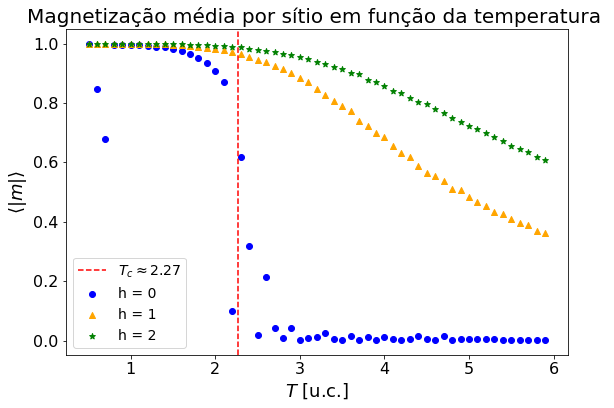

In [ ]:
# Mesmo sistema, mas agora para diferentes campos magnéticos
T = np.arange(0.5,6,0.1) # vetor de temperaturas
eps = 1 # parâmetro de energia
Nvar = 1000 # número de varreduras (pela metade para ganhar +tempo)
h = np.arange(0,3,1) # vetor de parâmetros do campo magnético

ax = plt.figure(figsize=(9,6))
markers = ['o', '^', '*']
colors = ['blue', 'orange', 'green']


for i in range (len(h)): # para cada tamanho de sistema
  sist = cria_sistema(10) # define um sistema randômico de spins
  mag_mean = [] # vetor para armazenar a magnetização media final obtida para cada temperatura

  for j in range(len(T)): # para cada temperatura
    sist_aux = np.copy(sist) # cria uma cópia do sistema formado
    mag = [] # vetor para armazenar a magnétização por sítio de cada iteração

    mag.append(calcula_Mag(sist_aux)) # calcula a primeira magnetização por sítio
    for k in range(Nvar): # para cada iteração
      TESTE_atualiza_Metropolis(T[j], eps, h[i], sist_aux) # atualiza a matriz de spins
      mag.append(calcula_Mag(sist_aux)) # calcula a magnetização por sítio
    
    mag_mean.append(np.abs(np.mean(mag))) # calcula a magnetização média total para a temperatura em questão
  
  ax = plt.scatter(T, mag_mean, linestyle='solid', marker=markers[i], label = 'h = {}'.format(h[i]) , color=colors[i], linewidth = 1)

plt.title('Magnetização média por sítio em função da temperatura ', fontsize=20)
plt.ylabel(r'$\langle |m| \rangle$', fontsize=18)
plt.xlabel('$T$ [u.c.]', fontsize=18)
plt.axvline(x = 2.27, color='red',linestyle='dashed', label=r'$T_c \approx 2.27$')
plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#mag_mean = [] # vetor para armazenar a magnetização média final obtida para cada temperatura
#sist = cria_sistema(10) # define um sistema de spins 50x50


### Análise complementar: susceptibilidade magnética

In [19]:
def derivada(fx, x, dx):
  df = [] # vetor para guardar a derivada de f 

  for i in range(len(x)):
    if i == 0:
      deriv = (fx[i+1] - fx[i])/dx
    elif i == len(x)-1:
      deriv = (fx[i] - fx[i-1])/dx
    else:
      deriv = (fx[i+1] - fx[i-1])/(2*dx)
    
    df.append(deriv)
  return df

In [ ]:
def derivada(fx, x, dx):
  df = [] # vetor para guardar a derivada de f 

  for i in range(len(x)):
    if i == 0:
      deriv = (fx[i+1] - fx[i])/dx
    elif i == len(x)-1:
      deriv = (fx[i] - fx[i-1])/dx
    else:
      deriv = (fx[i+1] - fx[i-1])/(2*dx)
    
    df.append(deriv)
  return df

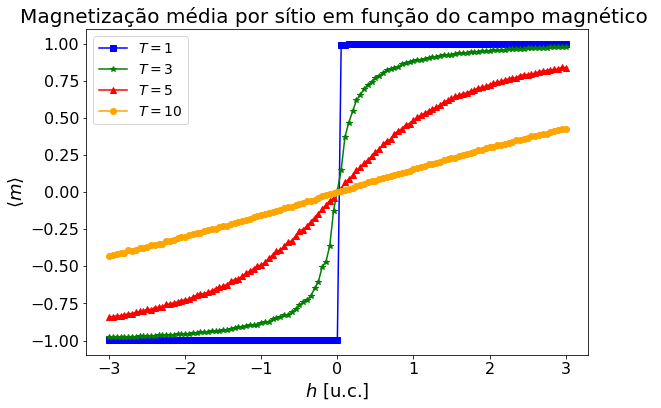

In [ ]:
# curva de susceptibilidade magnética

sist = cria_sistema(10) # define um sistema 10x10
eps = 1 # parâmetro de energia
T = [1,3,5,10] # vetor de temperaturas do sistema
dh = 0.05 # passo de campo magnético 
h = np.arange(-3, 3+dh, dh) # vetor de parâmetros de campo magnético
colors=['blue', 'green', 'red', 'orange'] # vetor de cores
markers=['s', '*', '^', 'o'] # vetor de marcadores
Nvar = 1000 # número de iterações a cada cálculo de <m>

ax = plt.figure(figsize=(9,6))

for i in range(len(T)): # para cada temperatura
  mag_mean = [] # vetor para guardar a média das magnetizações

  for j in range(len(h)): # para cada campo magnético
    sist_aux = np.copy(sist) # copia o sistema inicial de spins criado
    mag = [] # vetor para armazenar a magnetização do sistema para cada varredura

    mag.append(calcula_Mag(sist_aux)) # calcula a magnetização por sítico inicial do sistema criado
    for k in range(Nvar): # para cada varredura
      TESTE_atualiza_Metropolis(T[i], eps, h[j], sist_aux) # atualiza o sistema
      mag.append(calcula_Mag(sist_aux)) # calcula a magnetização por sítio e guarda

    mag_mean.append(np.mean(mag)) # armazena a magnetização média do sistema

  # Apresenta o gráfico correspondente
  ax = plt.plot(h, mag_mean, label=r'$T = {}$'.format(T[i]), color=colors[i], marker=markers[i])


plt.title('Magnetização média por sítio em função do campo magnético ', fontsize=20)
plt.ylabel(r'$\langle m \rangle$', fontsize=18)
plt.xlabel('$h$ [u.c.]', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
#plt.ylim(-1,1)
plt.show()

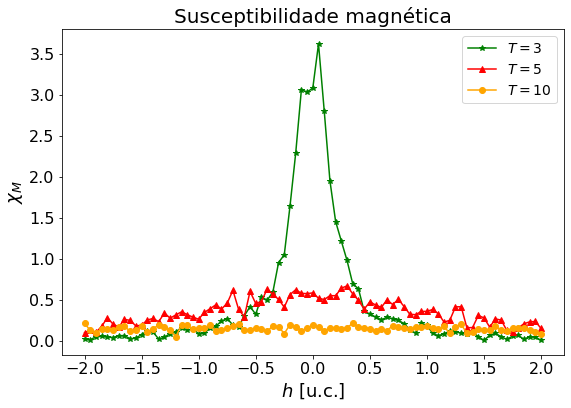

In [ ]:
# susceptibilidade magnética
sist = cria_sistema(10) # define um sistema 10x10
eps = 1 # parâmetro de energia
T = [1,3,5,10] # vetor de temperaturas do sistema
dh = 0.05 # passo de campo magnético 
h = np.arange(-2, 2+dh, dh) # vetor de parâmetros de campo magnético
colors=['blue', 'green', 'red', 'orange'] # vetor de cores
markers=['s', '*', '^', 'o'] # vetor de marcadores
Nvar = 1000 # número de iterações a cada cálculo de <m>

ax = plt.figure(figsize=(9,6))

for i in range(len(T)): # para cada temperatura
  mag_mean = [] # vetor para guardar a média das magnetizações

  for j in range(len(h)): # para cada campo magnético
    sist_aux = np.copy(sist) # copia o sistema inicial de spins criado
    mag = [] # vetor para armazenar a magnetização do sistema para cada varredura

    mag.append(calcula_Mag(sist_aux)) # calcula a magnetização por sítico inicial do sistema criado
    for k in range(Nvar): # para cada varredura
      TESTE_atualiza_Metropolis(T[i], eps, h[j], sist_aux) # atualiza o sistema
      mag.append(calcula_Mag(sist_aux)) # calcula a magnetização por sítio e guarda

    mag_mean.append(np.mean(mag)) # armazena a magnetização média do sistema
  x_m = derivada(mag_mean, h, dh)

  # Apresenta o gráfico correspondente
  if i > 0:
    ax = plt.plot(h, x_m, label=r'$T = {}$'.format(T[i]), color=colors[i], marker=markers[i])

plt.title('Susceptibilidade magnética', fontsize=20)
plt.ylabel(r'$\chi_M$', fontsize=18)
plt.xlabel('$h$ [u.c.]', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.show()